<a target="_blank" href="https://colab.research.google.com/github/cohere-ai/notebooks/blob/main/notebooks/llmu/RAG_with_Connectors.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# RAG with Connectors

This notebook shows how to build a RAG-powered chatbot with Cohere's Chat endpoint using connectors. The chatbot can extract relevant information from external documents and produce verifiable, inline citations in its responses.

Read the accompanying [article here](https://txt.cohere.com/rag-connectors/).

Connectors are ways of connecting to data sources. These data sources could be internal documents, document databases, the broader internet, or any other source of context which can inform the replies generated by the model.

We'll use the web search connector, a Cohere-managed connector that you can use without additional setup.

The diagram below provides an overview of what we’ll build.

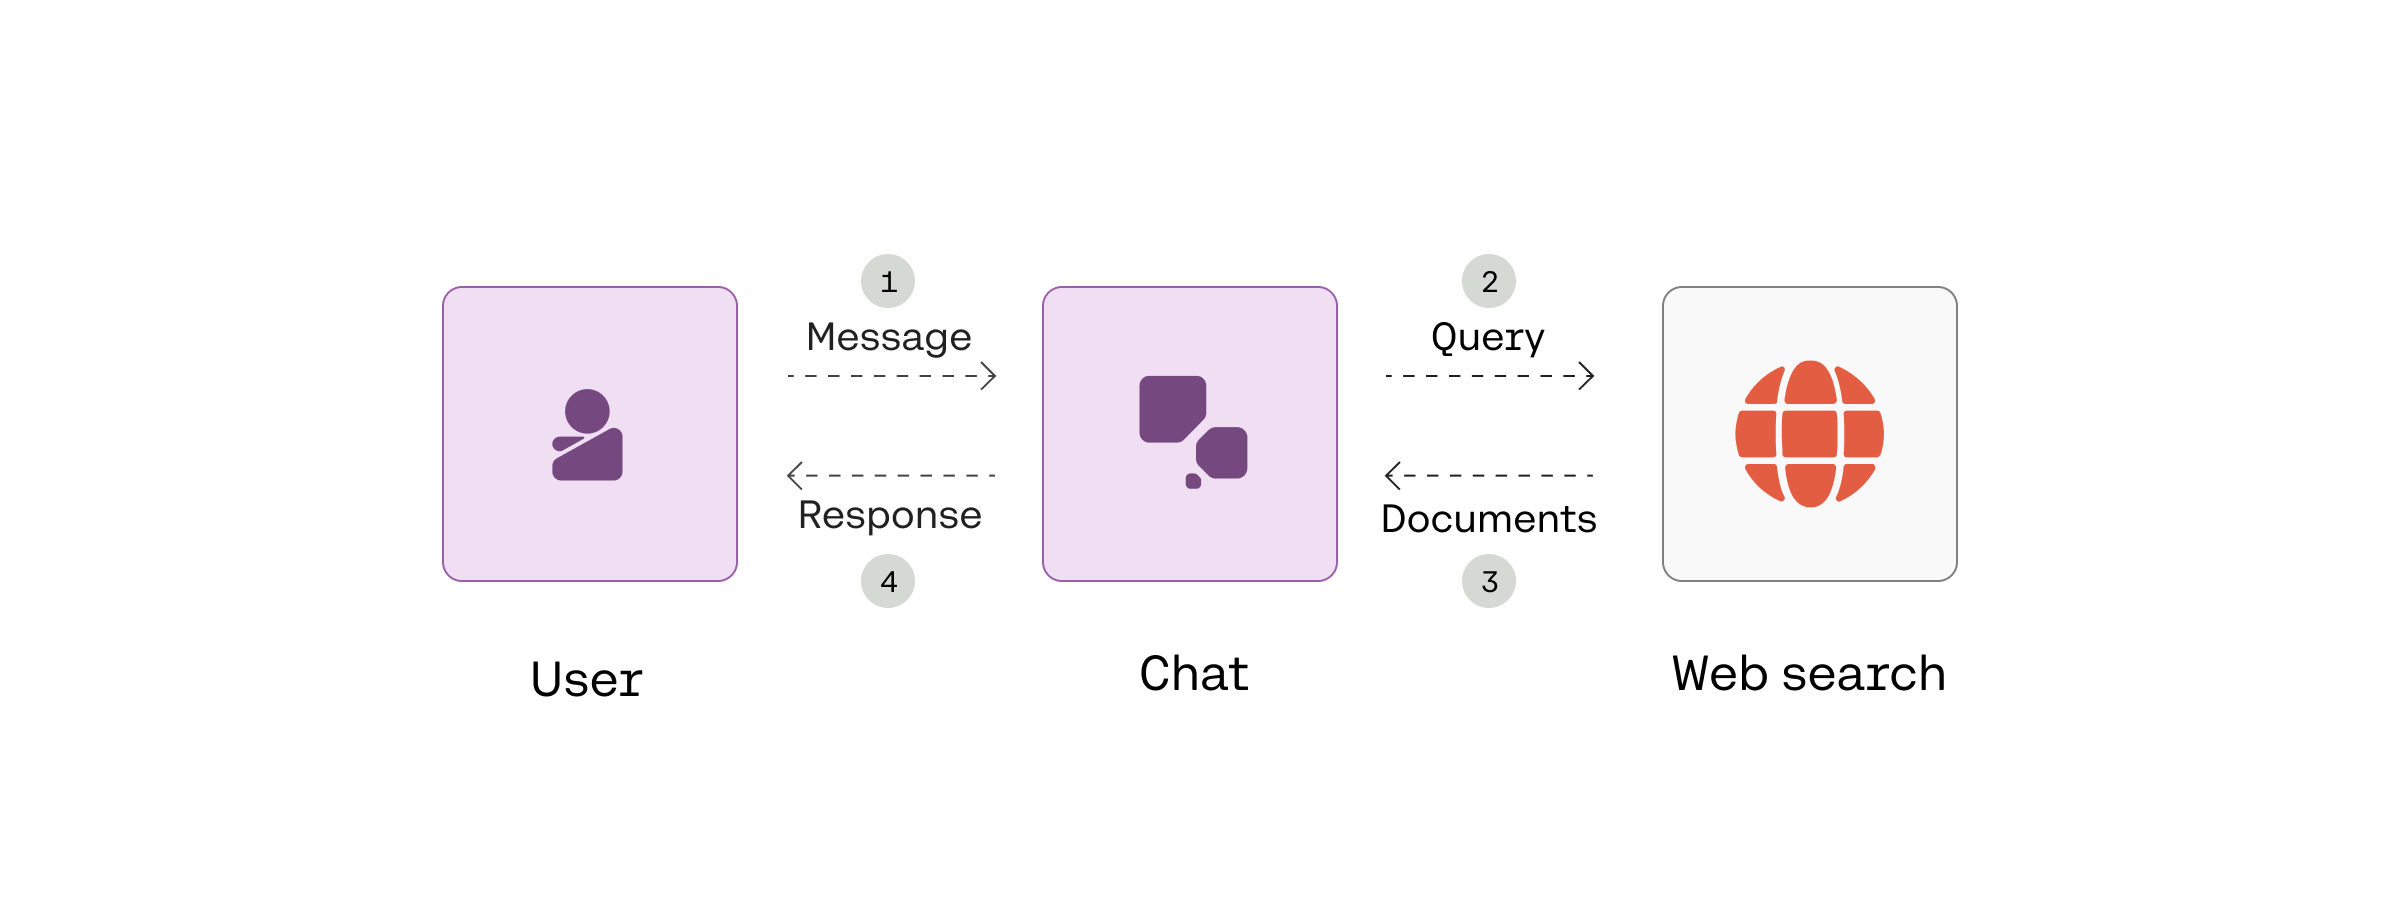

# Setup

In [ ]:
! pip install cohere -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.8 MB/s eta 0:00:00


In [ ]:
import uuid
import cohere
from cohere import ChatConnector
from typing import List

co = cohere.Client("COHERE_API_KEY") # Get your API key here: https://dashboard.cohere.com/api-keys

In [ ]:
#@title Enable text wrapping in Google Colab

from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

# Create a chatbot

In connector mode, most of the implementation is taken care of by the endpoint, including deciding whether to retrieve information, generating queries, retrieving documents, chunking and reranking documents (post-retrieval), and generating the response. This greatly simplifies our code.

The `Chatbot` class below handles the interaction between the user and chatbot.  We define the connector for the chatbot to use with the attribute `self.connectors`. In this notebook, we will use Cohere's `“web-search”` connector, which runs searches against a browser in safe mode.

The run() method contains the logic for getting the user message, displaying the chatbot response with citations, along with a way for the user to end the conversation.

Then, the chatbot responds to the user message.  We call `co.chat()` and supply a `connectors` parameter to make the chatbot component use connector mode.  All of the remaining implementation is taken care of by the endpoint, up to generating the response.

We also pass the `conversation_id` parameter, which retains the interactions between the user and the chatbot in the same conversation thread. We enable the `stream` parameter so we can stream the chatbot response.

We then print the chatbot's response.  In the case that the external information was used to generate a response, we also display documents and in-line citations.

In [ ]:
class Chatbot:
    def __init__(self, connectors: List[str]):
        """
        Initializes an instance of the Chatbot class.

        """
        self.conversation_id = str(uuid.uuid4())
        self.connectors = [ChatConnector(id=connector) for connector in connectors]

    def run(self):
        """
        Runs the chatbot application.

        """
        while True:
            # Get the user message
            message = input("User: ")

            # Typing "quit" ends the conversation
            if message.lower() == "quit":
                print("Ending chat.")
                break
            # else:                         # Uncomment for Google Colab to avoid printing the same thing twice
            #     print(f"User: {message}") # Uncomment for Google Colab to avoid printing the same thing twice

            # Generate response
            response = co.chat_stream(
                    message=message,
                    model="command-r",
                    conversation_id=self.conversation_id,
                    connectors=self.connectors,
            )

            # Print the chatbot response, citations, and documents
            print("\nChatbot:")
            citations = []
            cited_documents = []

            # Display response
            for event in response:
                if event.event_type == "text-generation":
                    print(event.text, end="")
                elif event.event_type == "citation-generation":
                    citations.extend(event.citations)
                elif event.event_type == "search-results":
                    cited_documents = event.documents

            # Display citations and source documents
            if citations:
              print("\n\nCITATIONS:")
              for citation in citations:
                print(citation)

              print("\nDOCUMENTS:")
              for document in cited_documents:
                print({'id': document['id'],
                      'snippet': document['snippet'][:50] + '...',
                      'title': document['title'],
                      'url': document['url']})

            print(f"\n{'-'*100}\n")

# Run the chatbot

We can now run the chatbot.  For this, we create the instance of `Chatbot` using Cohere's managed web-search connector.  Then we run the chatbot by invoking the `run()` method.

The format of each citation is:
- `start`: The starting point of a span where one or more documents are referenced
- `end`: The ending point of a span where one or more documents are referenced
- `text`: The text representing this span
- `document_ids`: The IDs of the documents being referenced (`doc_0` being the ID of the first document passed to the `documents` creating parameter in the endpoint call, and so on)

In [ ]:
# Define the connector
connectors = ["web-search"]

# Create an instance of the Chatbot class
chatbot = Chatbot(connectors)

# Run the chatbot
chatbot.run()

User: What is Cohere's LLM University

Chatbot:
LLM University, offered by Cohere, is a set of comprehensive learning resources for anyone interested in Natural Language Processing (NLP), from beginners to advanced learners. The curriculum aims to provide a solid foundation in NLP and equips learners with the skills needed to develop their own AI applications.
The course covers various topics, including semantic search, generation, classification, embeddings, and other NLP techniques. Learners can explore these concepts through hands-on exercises and practical code examples.
Join the Discord community to connect with other learners and access the latest updates!

CITATIONS:
start=27 end=33 text='Cohere' document_ids=['web-search_0', 'web-search_1']
start=47 end=79 text='comprehensive learning resources' document_ids=['web-search_1']
start=105 end=132 text='Natural Language Processing' document_ids=['web-search_0', 'web-search_1']
start=133 end=138 text='(NLP)' document_ids=['web-search